In [1]:
#import pandas to import and read file
#get info for dataset

import pandas as pd

filename='medical_time_series .csv'
mrd=pd.read_csv(filename)
mrd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [2]:
#both columns have 731/731 non-null values
#therefore, there is no missing data to treat
#investigate if there are any duplicate values

mrd.duplicated().value_counts()

False    731
Name: count, dtype: int64

In [3]:
#no duplicates to treat
#check for outliers within our Revenue variable
#import stats to use zscores

from scipy import stats

mrd['zscore_Revenue']=stats.zscore(mrd['Revenue'])
sum((mrd.zscore_Revenue<-3) | (mrd.zscore_Revenue>3))

0

In [4]:
#drop zscore column that was created

mrd=mrd.drop(['zscore_Revenue'], axis=1)

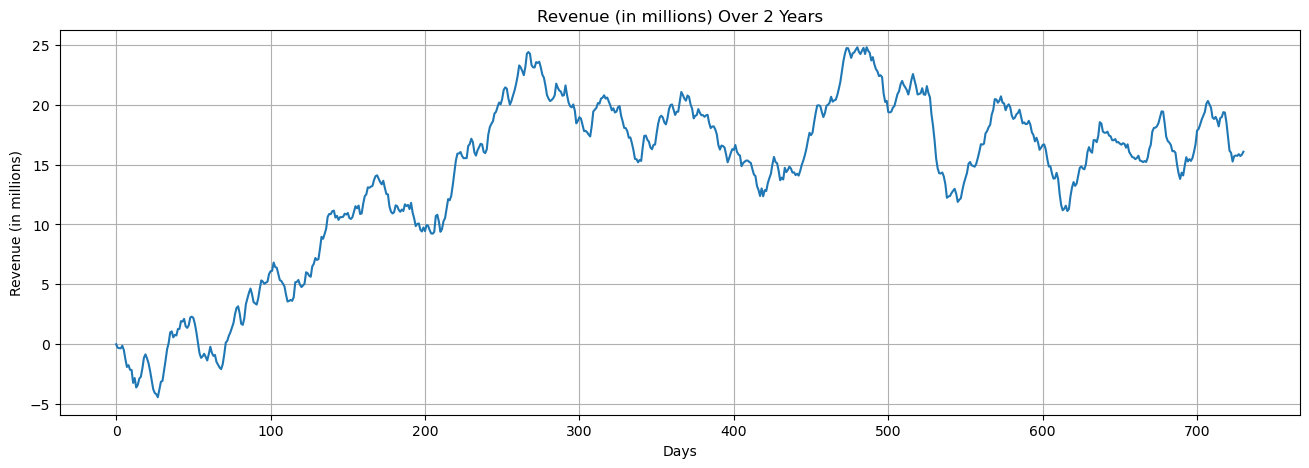

In [5]:
#based on zscores, no outliers are present
#therefore no need to drop/impute/treat
#import matplotlib for visualization purposes
#visualize line graph

import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.plot(mrd['Revenue'])
plt.title('Revenue (in millions) Over 2 Years')
plt.xlabel('Days')
plt.ylabel('Revenue (in millions)')
plt.grid(True)
plt.show()

In [6]:
#now convert Day column to datetime format
#use 1/1/2016 as start date
#inspect data to make sure data is proprely formatted

start_date=pd.to_datetime('2016-01-01')
mrd['Day']=pd.to_timedelta(mrd['Day']-1, unit='D')+start_date
mrd.set_index('Day', inplace=True)
mrd.head()

,Revenue
Day,
2016-01-01,0.000000
2016-01-02,-0.292356
2016-01-03,-0.327772
2016-01-04,-0.339987
2016-01-05,-0.124888


In [7]:
#check stationarity of data using Augmented Dickey-Fuller (ADF) test
#import test from statsmodels
#print results

from statsmodels.tsa.stattools import adfuller

adf_results=adfuller(mrd['Revenue'])
print("Test statistic: ", adf_results[0])
print("P-value: ", adf_results[1])
print("Critical values: ", adf_results[4])

Test statistic:  -2.2183190476089454
P-value:  0.19966400615064356
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [8]:
#p-value of 0.1997 > 0.05, indicating data is non-stationary
#difference it to make it stationary

mrd_diff=mrd.diff()
mrd_diff.head()

,Revenue
Day,
2016-01-01,NaN
2016-01-02,-0.292356
2016-01-03,-0.035416
2016-01-04,-0.012215
2016-01-05,0.215100


In [9]:
#run ADF test again to confirm data is now stationary

adf_results=adfuller(mrd_diff['Revenue'].dropna())
print("Test statistic: ", adf_results[0])
print("P-value: ", adf_results[1])
print("Critical values: ", adf_results[4])

Test statistic:  -17.374772303557066
P-value:  5.113206978840172e-30
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [10]:
#p-value is now < 0.05, indicating data is now stationary
#export dataset to own csv file for submission

mrd_diff.to_csv('d213_t1_diff.csv')

In [11]:
#now split time series data into a training set and testing set
#use 80/20 split
#verify data is split correctly

split_index = int(len(mrd_diff) * 0.8)

train_set = mrd_diff.iloc[:split_index]
test_set = mrd_diff.iloc[split_index:]

print("Train shape:", train_set.shape)
print("Test shape:", test_set.shape)

Train shape: (584, 1)
Test shape: (147, 1)


In [12]:
#export these sets to their own csv files for submission

train_set.to_csv('d213_t1_train.csv')
test_set.to_csv('d213_t1_test.csv')

<Axes: xlabel='Day'>

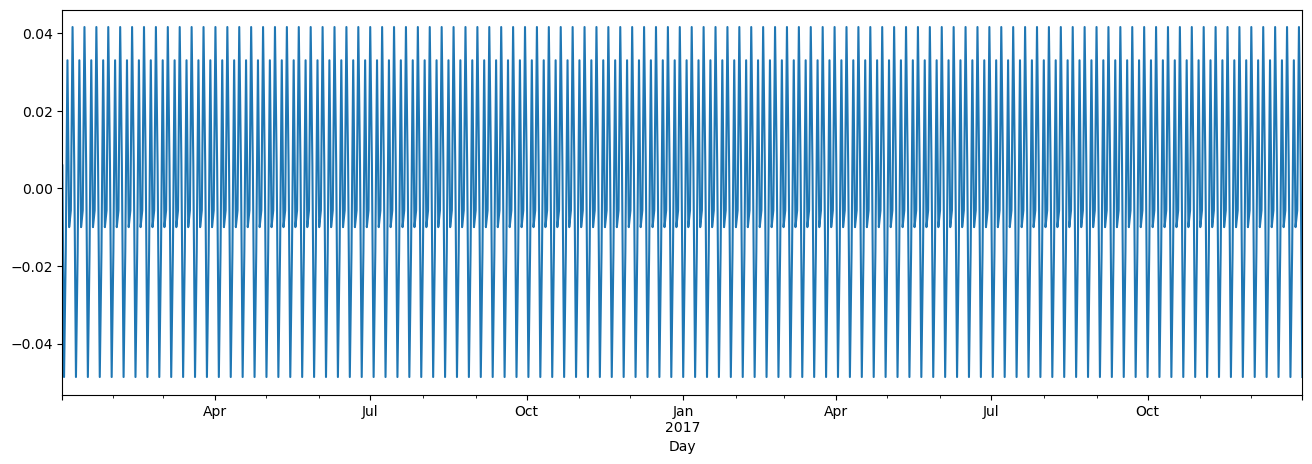

In [13]:
#visualize seasonal component, or lack thereof, or our differenced data
#import seasonal_decompose for this purpose
#use 7 periods for 7 days, or weekly

from statsmodels.tsa.seasonal import seasonal_decompose

decomp=seasonal_decompose(mrd_diff.dropna(), period=7)
plt.figure(figsize=(16,5))
decomp.seasonal.plot()

<Axes: xlabel='Day'>

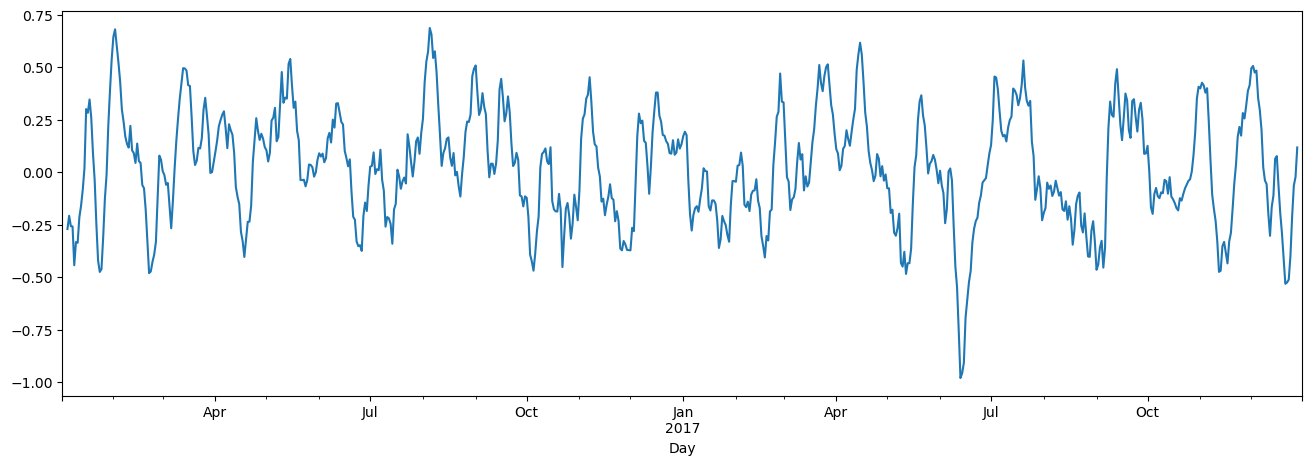

In [14]:
#now visualize the trends

plt.figure(figsize=(16,5))
decomp.trend.plot()

Text(0.5, 1.0, 'Partial ACF (PACF)')

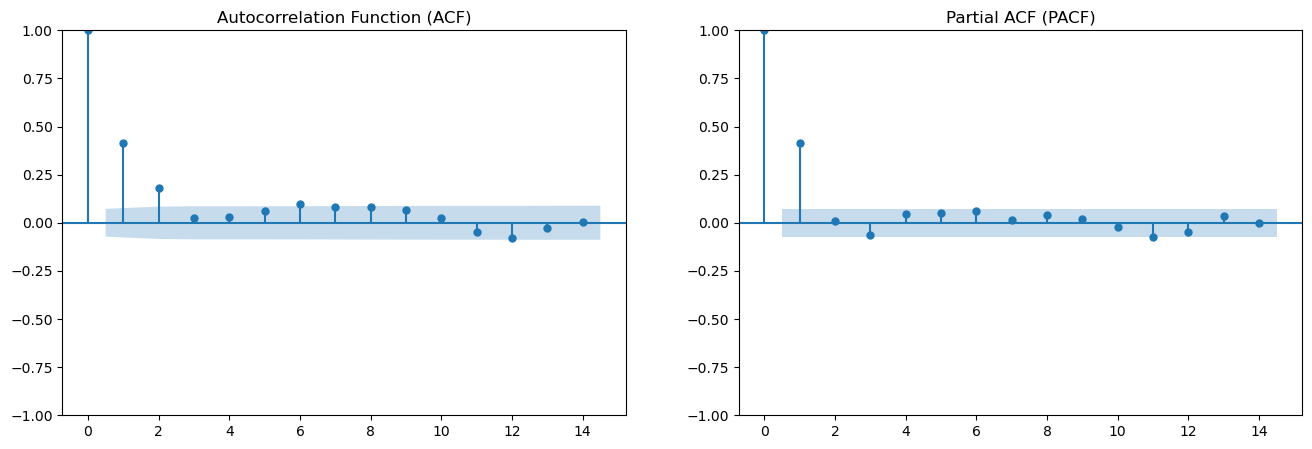

In [15]:
#now visualize the autocorrelation function (ACF) and partial ACF (PACF)
#import plot_acf, plot_pacf from statsmodels for this purpose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs=plt.subplots(1, 2, figsize=(16,5))

plot_acf(mrd_diff.dropna(), lags=14, alpha=0.05, ax=axs[0])
axs[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(mrd_diff.dropna(), lags=14, alpha=0.05, ax=axs[1])
axs[1].set_title('Partial ACF (PACF)')

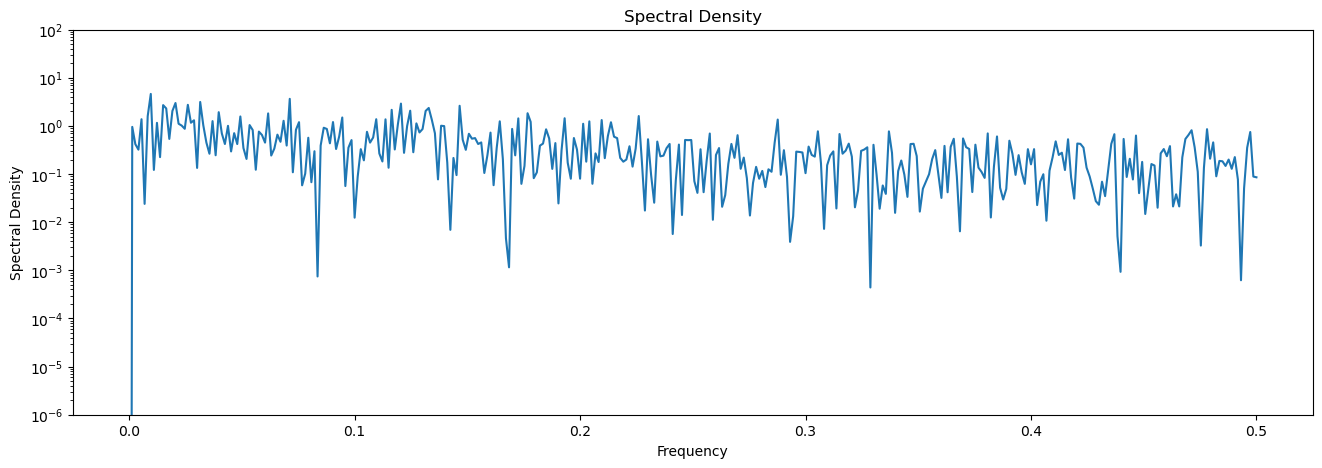

In [16]:
#visualize spectral density
#import signal/periodogram for our purposes

from scipy import signal

plt.figure(figsize=(16,5))
f, pow_den = signal.periodogram(mrd_diff['Revenue'].dropna())
plt.semilogy(f, pow_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

<Figure size 1600x500 with 0 Axes>

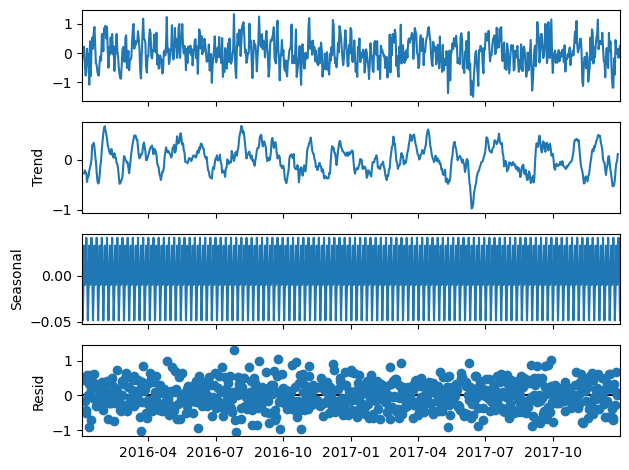

In [17]:
#now visualize decomposed time series
#uses decomp from seasonal_decompose above
#plot the different graphs (trend, seasonality, residual)

plt.figure(figsize=(16,5))
decomp.plot()
plt.show()

<Axes: title={'center': 'Residuals'}, xlabel='Day'>

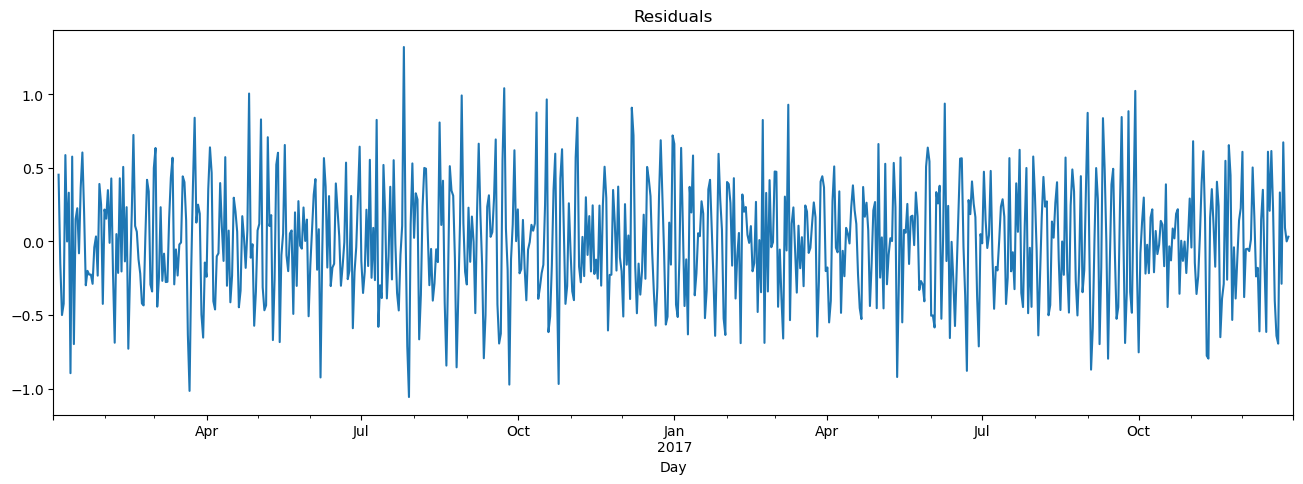

In [18]:
#now visualize the lack of trends in the residuals of the decomposed series
#once again using decomp from above

plt.figure(figsize=(16,5))
plt.title('Residuals')
decomp.resid.plot()

In [19]:
#import auto_arima
#use auto_arima to confirm best model for our purposes
#get a summary of findings

from pmdarima import auto_arima

stepwise_fit=auto_arima(mrd['Revenue'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1015.481, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.982, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.911, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.927, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=905.166, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.947, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.419 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.991
Date:                Wed, 16 Apr 2025   AIC                            879.982
Time:                        17:18:11   BIC                            889.168
Sample:                    01-01-2016   HQIC                           883.526
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
#according to our auto_arima results above, we should use a SARIMAX model
#this accounts for the seasonality shown in the visualization above
#our best model is SARIMAX(1,1,0)
#import SARIMAX to set up our model and get results

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model=SARIMAX(train_set['Revenue'], order=(1,1,0))
sarimax_res=sarimax_model.fit(disp=False)
print(sarimax_res.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -428.622
Date:                Wed, 16 Apr 2025   AIC                            861.243
Time:                        17:18:11   BIC                            869.980
Sample:                    01-01-2016   HQIC                           864.649
                         - 08-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3184      0.040     -7.994      0.000      -0.396      -0.240
sigma2         0.2486      0.017     14.931      0.000       0.216       0.281
Ljung-Box (L1) (Q):                   1.22   Jarque-

/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Day'>

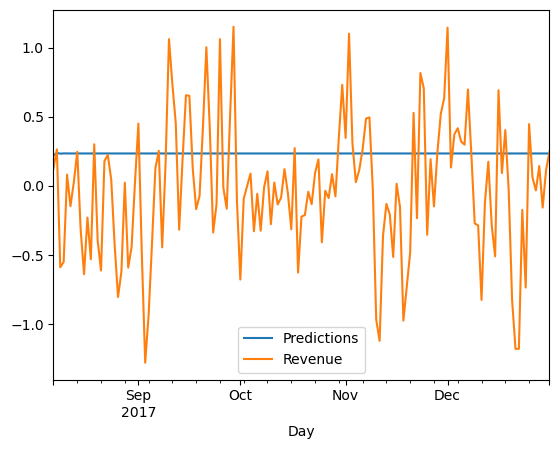

In [21]:
#now we can calculate the predictions for our test set
#visualize these predictions vs actual

start=len(train_set)
end=len(train_set)+len(test_set)-1

predictions=sarimax_res.predict(start, end, typ='levels').rename('Predictions')
predictions.plot(legend=True)
test_set['Revenue'].plot(legend=True)

In [22]:
#evaluate our model using mean squared error (MSE) and root MSE (RMSE)
#import from sklearn for our purposes

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse 

print("MSE: ", round(mean_squared_error(test_set['Revenue'], predictions),4))
print("RMSE: ", round(rmse(test_set['Revenue'], predictions),4))

MSE:  0.2997
RMSE:  0.5474


In [23]:
#train our model on the full dataset now

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(mrd, test_size=0.2, shuffle=False, random_state=42)

sarimax_model = SARIMAX(mrd['Revenue'], order=(1, 1, 0))
sarimax_res = sarimax_model.fit(disp=False)

start = len(train_set)
end = len(train_set) + len(test_set) - 1

predictions = sarimax_res.predict(start=start, end=end, typ='levels')

/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


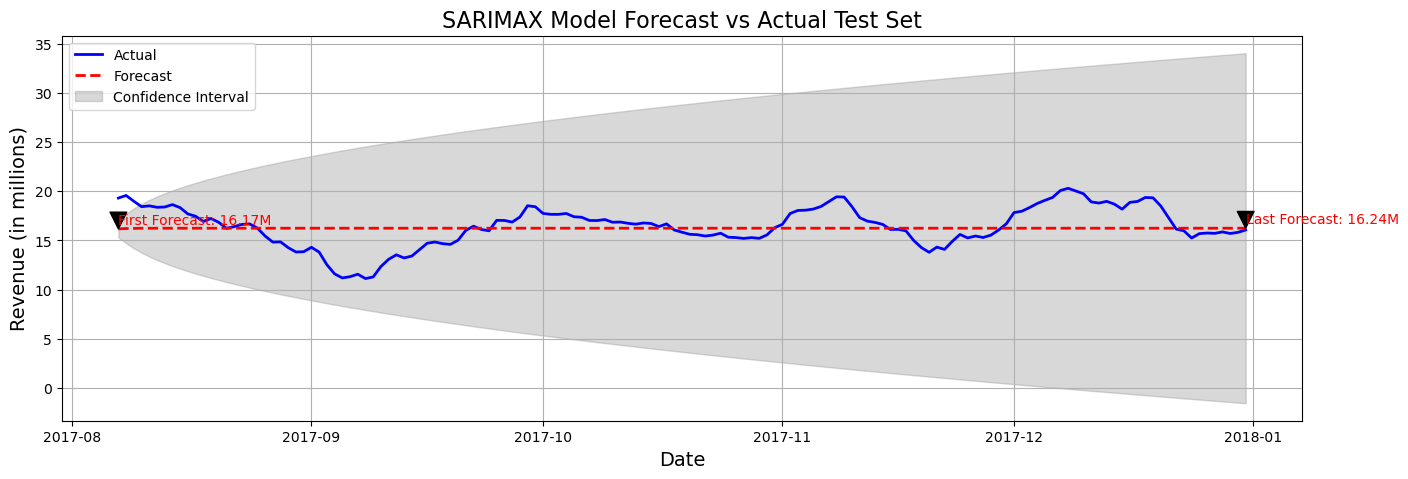

In [24]:
#plot our forecasted values vs actual test set values
#shade for our confidence interval range
#print our first forecasted value and last forecasted value

forecast_obj = sarimax_res.get_forecast(steps=len(test_set))
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

plt.figure(figsize=(16,5))
plt.plot(test_set.index, test_set['Revenue'], label='Actual', color='blue', linewidth=2)
plt.plot(test_set.index, forecast_mean, label='Forecast', color='red', linestyle='--', linewidth=2)

plt.fill_between(test_set.index,
                 conf_int.iloc[:, 0],  # lower bound
                 conf_int.iloc[:, 1],  # upper bound
                 color='gray', alpha=0.3, label='Confidence Interval')

plt.annotate(f'First Forecast: {forecast_mean.iloc[0]:.2f}M', 
             xy=(test_set.index[0], forecast_mean.iloc[0]), 
             xytext=(test_set.index[0], forecast_mean.iloc[0] + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='red')

plt.annotate(f'Last Forecast: {forecast_mean.iloc[-1]:.2f}M', 
             xy=(test_set.index[-1], forecast_mean.iloc[-1]), 
             xytext=(test_set.index[-1], forecast_mean.iloc[-1] + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='red')

plt.title('SARIMAX Model Forecast vs Actual Test Set', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Revenue (in millions)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()